# Отток клиентов

Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Оглавление:
* [1. Подготовка данных](#1)
* [2. Исследование задачи](#2)
* [3. Борьба с дисбалансом](#3)
* [4. Тестирование модели](#4)
* [Чек-лист готовности проекта](#5)

# 1. Подготовка данных <a class="anchor" id="1"></a>

Импортируем библиотеки:

In [1]:
# <импорт библиотеки pandas>
import pandas as pd

# <импорт библиотеки math>
import math

# <импорт библиотеки sklearn>
import sklearn

# <Отключение предупреждений>
import warnings
warnings.filterwarnings('ignore')

# <импорт библиотеки numpy>
import numpy as np

# <импорт библиотеки seaborn для построения графиков>
import seaborn as sns

Прочитаем файл с данными:

In [2]:
# <чтение файла с данными с сохранением в переменную df>
df = pd.read_csv('/datasets/Churn.csv')

Рассмотрим информацию по датафрейму и первые 5 строк:

In [3]:
# <рассмотрим датафрейм df>
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Имеются пропуски в признаке *Tenure* — количество недвижимости у клиента. Если в количестве недвижимости пропуски, самым разумным предположением выглядит тот факт что недвижимости у клиента нет (живет у родственников или снимает квартиру, например).

In [4]:
# <Заменим значения количества недвижимости равные NaN на 0> 
df['Tenure'] = (
np.where((np.isnan(df.Tenure)), 0, df.Tenure)
)

Сменим тип данных на целочисленный в этом столбце, мне кажется в реальных задачах это было бы кстати, например для экономии памяти.

In [5]:
# <поменяем тип на целочисленный>
df['Tenure'] = df['Tenure'].astype('int64')

Создадим новый датафрейм, удалим из него столбцы *Surname* и *RowNumber*, которые не влияют на столбец *Exited*. 
* Клиенты в датафрейме расположены не по порядку возрастания *CustomerId*, который может в теории указывать нам на то, насколько давно клиент сотрудничает с банком, соответственно номер строки никак не влияет на наш целевой признак. 
* Различных фамилий в датафрейме более двух тысяч, соответственно использовав их мы только усложним модель.

In [6]:
# <сбросим два столбца, которые не помогу нам предсказать целевой признак>
df_ohe = df.drop(['Surname','RowNumber'], axis=1)

Преобразуем категориальные признаки в количественные с помощью техники прямого кодирования (**OHE**), в этом поможет метод *.get_dummies*. Также проставим аргумент *drop_first = True*, чтобы один из столбцов наших фиктивных переменных для каждого признака был сброшен(это нужно чтобы не угодить в так называемую *дамми-ловушку*, когда фиктивных признаков слишком много). 

In [7]:
# <Преобразуем категориальные признаки в фиктивные переменные, и сбросим по одному из них у каждого признака.>
df_ohe = pd.get_dummies(df_ohe, drop_first=True)

Взглянем на датафрейм:

In [8]:
# <Посмотрим первые 5 строк преобразованного датафрейма>
print(df_ohe.info())
df_ohe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
CustomerId           10000 non-null int64
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(2), int64(8), uint8(3)
memory usage: 810.7 KB
None


,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Разобьем данные на две выборки: обучающую + валидационную и тестовую. Разобьем их в отношении 4:1, попробуем использовать в этом проекте кросс-валидацию, проставив относящийся к ней аргумент в методе *GridSearchCV*:

In [9]:
# <Импортируем функцию из бибилиотеки sklearn>
from sklearn.model_selection import train_test_split

In [10]:
# <Разделим обучающий датафрейм на features и target - целевой признак>
target = df_ohe['Exited']
features = df_ohe.drop('Exited', axis=1)

# <Поделим датафрейм на обучающую выборку + валидационную выборку (которая далее будет использована для кросс-валидации) и тестовую выборку.>
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

Проведем масштабирование признаков:

In [11]:
# <импортируем StandardScaler из библиотеки sklearn>
from sklearn.preprocessing import StandardScaler

In [12]:
# <конкретизируем какие признаки будем масшатбировать>
numeric = ['CustomerId', 'CreditScore', 'Age', 'Tenure','Balance', 'NumOfProducts', 'EstimatedSalary']

In [13]:
# <Проведем масштабирование features_train>
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Вывод

* Мы осмотрели данные и заполнили пропуски самым очевидным образом.
* Мы сменили тип данных, так как количество недвижимости дробится не может, и целочисленный тип здесь подходит лучше
* Мы удалили из датафрейма столбцы, которые никак не помогут вычислить целевой признак.
* Преобразовали категориальные признаки в количественные с помощью техники прямого кодирования (OHE), создали для этих признаков количественные фиктивные переменные.
* Провели масштабирование признаков, чтобы алгоритм обучения не делал выводов о том что тот или иной признак важнее только из-за того что он измеряется в больших числах.
* Разделили данные на обучающую + валидационную и тестовую выборки. Первую будем использовать для обучения и валидации когда будем перебирать гиперпараметры с помощью *GridSearchCV* - метода для исчерпывающего поиска по сетке гиперпараметров.

# 2. Исследование задачи <a class="anchor" id="2"></a>

Исследуем баланс классов:

0    0.7963
1    0.2037
Name: Exited, dtype: float64


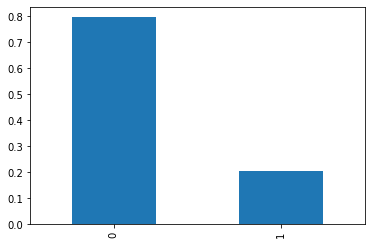

In [14]:
class_frequency = target.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

80% клиентов в датафрейме из банка не уходят - в классах дисбаланс. Идеальным балансом чтобы строить модели можно было бы назвать распределение 50/50. Попробуем обучить модель, несмотря на дисбаланс.

Попробуем использовать *GridSearchCV* для подбора параметров модели дерева принятия решений. Я слышал что использование таких методов не рекомендуется в проекте без понимания того что в них происходит, поэтому постараюсь разъяснить код:

* *param_grid* это словарь в котором указываются гиперпараметры и интервалы в которых они могут находится, или в случае если это категориальные признаки - возможные значения.
* в *np.arange* в качестве третьего аргумента шаг. Первый и второй аргумент - начало и конец последовательности. np.arange(0.5, 1, 0.1) - тут в последовательности не будет единицы но будет [0.5, 0.6, 0.7, 0.8, 0.9].
* *max_leaf_nodes* - максимальное количество листовых узлов (нижние узлы с ответами).
* *max_features* - количеcтво используемых признаков.
* *min_samples_split* - минимальное число объектов, при котором выполняется расщепление на узлы.
* аргумент *cv* необходим для кросс-валидации, я изучил следующий спринт после этого, и поэтому имею представление о ней. Я выбрал 4 блока, так как ранее нам рекомедовали делить выборку на обучающую, валидационную и тестовую в соотношении 3:1:1. Соответственно 4 фолда это три фолда для обучения и один для валидации.
* аргумент *scoring* указывает как будем оценивать модели, для моделей классификации необходимо использовать F1-меру.

In [15]:
%%time
# <импортируем алгоритм исчерпывающего поиска по гиперпараметрам>
from sklearn.model_selection import GridSearchCV
# <Импортируем метод дерева принятия решений>
from sklearn.tree import DecisionTreeClassifier


# <сетка гиперпараметров, по которой будет происходит исчерпывающий поиск>
param_grid = {
    'max_depth': [None] + list(np.arange(2, 21,2).astype(int)),
    'max_features': ['auto', 'sqrt', None],
    'max_leaf_nodes': [None] + list(np.arange(10, 101, 10).astype(int)),
    'min_samples_split': [2, 5, 10]
}

# <дерево принятия решений к которому будем подбирать параметры>
estimator = DecisionTreeClassifier(random_state = 12345)

# <модель>
model = GridSearchCV(estimator, param_grid, cv=4, scoring = 'f1')

# <обучаем модель> 
model.fit(features_train, target_train)

CPU times: user 1min 21s, sys: 156 ms, total: 1min 21s
Wall time: 1min 21s


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=12345,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 16, 18,
                                       20],
              

In [16]:
# <среднее значение F1-меры по разным выборкам>
model.best_score_

0.5778748424367518

Оценка неплоха, близка к оценке, к которой мы стремимся.

Чтобы посчитать для этой модели *AUC-ROC*, пришлось поднапрячься. В данном блоке мы импортируем саму оценку, скидываем индексы выборкам, так как если этого не сделать, в некоторых строках будет *NaN*. Далее мы выбираем количество наших блоков кросс-валидации = 4. И затем подсчитываем *AUC_ROC* для каждого варианта обучающей и валидационной выборки. Затем подсчитываем их среднее и получаем финальную оценку:

In [17]:
from sklearn.metrics import roc_auc_score

features_train = features_train.reset_index(drop = True)
target_train = target_train.reset_index(drop = True)

auc_roc_scores = []

sample_size = int(len(features_train)/4)

for i in range(0, len(features_train), sample_size):
    valid_indexes = list(range(i, i + sample_size))
    train_indexes = list(range(0,len(features_train)))
    del train_indexes[i:(i + sample_size)]
    
    features_valid = features_train.loc[valid_indexes,]
    target_valid = target_train.loc[valid_indexes,]
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid,probabilities_one_valid)
        
    auc_roc_scores.append(auc_roc)

auc_roc_scores = pd.Series(auc_roc_scores)
final_score = auc_roc_scores.mean()
final_score

0.8716567180657411

Эта оценка выше 0.5, а значит проходит проверку на адекватность. Но нам относительно далеко до идеальной оценки = 1.

In [18]:
# <набор параметров, которые подобрал исчерпывающий поиск по гиперпараметрам модели.>
model.best_params_

{'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 60,
 'min_samples_split': 2}

Попробуем *RandomizedSearchCV* - случайный поиск по гиперпараметрам с моделью случайного леса.
* *bootstrap* - Бутстрэп-агрегирование или бэггинг, алгоритм предназначенный для улучшения стабильности и точности алгоритмов машинного обучения, также уменьшает дисперсию и помогает избежать переобучения. 

In [19]:
%%time
# <Импортируем алгоритм случайного леса>
from sklearn.ensemble import RandomForestClassifier
# <Импортируем алгоритм случайного поиска по гиперпараметрам>
from sklearn.model_selection import RandomizedSearchCV


# <сетка гиперпараметров, по которой будет происходит случайный поиск>
param_grid = {
    'n_estimators': list(np.arange(2, 101, 2).astype(int)),
    'max_depth': [None] + list(np.arange(2, 21,2).astype(int)),
    'max_features': ['auto', 'sqrt', None],
    'max_leaf_nodes': [None] + list(np.arange(10, 101, 10).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# <случайный лес к которому будем подбирать параметры>
estimator = RandomForestClassifier(random_state = 12345)

# <модель>
model_rf = RandomizedSearchCV(estimator, param_grid, cv=4, scoring = 'f1')

# <обучаем модель> 
model_rf.fit(features_train, target_train)

CPU times: user 13.8 s, sys: 36 ms, total: 13.8 s
Wall time: 13.9 s


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [20]:
# <среднее значение F1-меры по разным выборкам>
model_rf.best_score_

0.5788257377531885

Оценка хуже чем у одного дерева принятия решений. Подсчитаем *AUC-ROC*:

In [21]:
from sklearn.metrics import roc_auc_score

auc_roc_scores = []

sample_size = int(len(features_train)/4)

for i in range(0, len(features_train), sample_size):
    valid_indexes = list(range(i, i + sample_size))
    train_indexes = list(range(0,len(features_train)))
    del train_indexes[i:(i + sample_size)]
    
    features_valid = features_train.loc[valid_indexes,]
    target_valid = target_train.loc[valid_indexes,]
    probabilities_valid = model_rf.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid,probabilities_one_valid)    
    
    auc_roc_scores.append(auc_roc)

auc_roc_scores = pd.Series(auc_roc_scores)
final_score = auc_roc_scores.mean()
final_score

0.9035105997475861

Оценка разнится в зависимости от отработки случайного поиска, но примерно равна таковой у дерева принятия решений.

In [22]:
# <набор параметров, которые подобрал исчерпывающий поиск по гиперпараметрам модели.>
model_rf.best_params_

{'n_estimators': 8,
 'min_samples_split': 10,
 'max_leaf_nodes': 100,
 'max_features': None,
 'max_depth': None,
 'bootstrap': True}

Попробуем логистическую регрессию:

In [23]:
# <Импортируем метод логистической регрессии>
from sklearn.linear_model import LogisticRegression
# <Импортируем функцию cross_val_score>
from sklearn.model_selection import cross_val_score

In [24]:
# <Создадим модель лог. регрессии,>
model_lr = LogisticRegression(random_state=12345)

# <Оценим качество модели, обученной в ходе перекрестной проверки>
score = cross_val_score(model_lr,features_train, target_train,cv=4,scoring='f1').mean()

# <обучаем модель> 
model_lr.fit(features_train, target_train)

# <выведем долю правильных ответов>
score

0.32185993064665314

Слабая оценка. В следующем пункте попробуем избавиться от дисбаланса, и снова обучить модель. Подсчитаем *AUC-ROC*:

In [25]:
from sklearn.metrics import roc_auc_score

auc_roc_scores = []

sample_size = int(len(features_train)/4)

for i in range(0, len(features_train), sample_size):
    valid_indexes = list(range(i, i + sample_size))
    train_indexes = list(range(0,len(features_train)))
    del train_indexes[i:(i + sample_size)]
    
    features_valid = features_train.loc[valid_indexes,]
    target_valid = target_train.loc[valid_indexes,]
    
    probabilities_valid = model_lr.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid,probabilities_one_valid)
        
    auc_roc_scores.append(auc_roc)

auc_roc_scores = pd.Series(auc_roc_scores)
final_score = auc_roc_scores.mean()
final_score

0.7684252256491437

Самая низкая оценка.

### Вывод

* Мы оценили сбалансированность целевого признака, и выяснили что в нем присутствует дисбаланс.
* Подобрали лучшие гиперпараметры для дерева принятия решений с помощью метода *GridSearchCV*.
* Подобрали гиперпараметры для случайного леса с помощью метода *RandomizedSearchCV*. Получили результат примерно равный результату у дерева принятия решений.
* Попробовали обучить логистическую регрессию, но получили оценку гораздо хуже чем у "деревянных" алгоритмов.

В следующем пункте избавимся от дисбаланса и снова обучим модель.

# 3. Борьба с дисбалансом <a class="anchor" id="3"></a>

Начнем, относительно, с начала. Это необходимо, так как кросс-валидацию и перебор параметров теперь нам придется проводить самостоятельно. Пришлось делать именно так из-за того я не имею представления как делать *upsampling* в методах аля  *GridSearchCV*, единственное что там обнаружено для баланса классов - *class_weight = 'balanced'*.

Импортируем оценку и функцию для *upsampling*:

In [26]:
# <импортируем оценку F1-меры>
from sklearn.metrics import f1_score

# <импортируем функцию resample>
from sklearn.utils import resample

В данном цикле происходит перебор моделей дерева принятия решений с различными гиперпараметрами, затем идет оценка модели на валидационной выборке, используется кросс-валидация, написанная на питоне. Она была изучена в следующем спринте. Также происходит апсемплинг положительного класса.

Здесь и далее будет происходит перебор не всех возможных значений гиперпараметров, я специально напишу код так, чтобы в переменной model была сохранена лучшая модель и можно было бы быстрее посчитать *AUC-ROC*.

In [27]:
%%time
for depth in range(2,7,2):
    for samples in [2, 5, 10]:
        model = DecisionTreeClassifier(random_state=0, max_depth=depth, 
                                               min_samples_split = samples
                                               )
                
        sample_size = int(len(features_train)/4)
        scores = []
        
        for i in range(0, len(features_train), sample_size):
            valid_indexes = list(range(i, i + sample_size))
            train_indexes = list(range(0,len(features_train)))
                    
            del train_indexes[i:(i + sample_size)]
                    
            features_train_1 = features_train.loc[train_indexes,]
            features_valid = features_train.loc[valid_indexes,]
            target_train_1 = target_train.loc[train_indexes,]
            target_valid = target_train.loc[valid_indexes,]
                    
            features_train_1['Exited'] = target_train_1
                
            features_train_majority = features_train_1[features_train_1.Exited==0]
            features_train_minority = features_train_1[features_train_1.Exited==1]
                    
            features_train_minority_upsampled = resample(features_train_minority, 
                                 replace=True,     
                                 n_samples=int(features_train_majority['Age'].count()),    
                                 random_state=123)
            
            features_train_upsampled = pd.concat([features_train_majority, features_train_minority_upsampled])
                    
                    
            target_train_upsampled = features_train_upsampled['Exited']
            features_train_upsampled = features_train_upsampled.drop('Exited', axis=1)
                    
            model.fit(features_train_upsampled, target_train_upsampled)
            predictions = model.predict(features_valid)
            score = f1_score(target_valid, predictions)
            scores.append(score)
                    
            if i == (sample_size * 3):
                scores = pd.Series(scores)
                print('max_depth =',depth,'min_samples_split =',samples,': {:.4f}'.format(scores.mean()))

max_depth = 2 min_samples_split = 2 : 0.5133
max_depth = 2 min_samples_split = 5 : 0.5133
max_depth = 2 min_samples_split = 10 : 0.5133
max_depth = 4 min_samples_split = 2 : 0.5252
max_depth = 4 min_samples_split = 5 : 0.5252
max_depth = 4 min_samples_split = 10 : 0.5252
max_depth = 6 min_samples_split = 2 : 0.5604
max_depth = 6 min_samples_split = 5 : 0.5604
max_depth = 6 min_samples_split = 10 : 0.5606
CPU times: user 1.69 s, sys: 8 ms, total: 1.7 s
Wall time: 1.72 s


Лучшая оценка у дерева с параметрами *max_depth* = 6, *min_samples_split* = 10. Она равна 0.5606. Она ниже чем у дерева, подобранного *GridSearchCV*. Но и гиперпараметров мы перебирали меньше. Подсчитаем *AUC-ROC*:

In [28]:
from sklearn.metrics import roc_auc_score

auc_roc_scores = []

sample_size = int(len(features_train)/4)

for i in range(0, len(features_train), sample_size):
    valid_indexes = list(range(i, i + sample_size))
    train_indexes = list(range(0,len(features_train)))
    del train_indexes[i:(i + sample_size)]
    
    features_valid = features_train.loc[valid_indexes,]
    target_valid = target_train.loc[valid_indexes,]
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid,probabilities_one_valid)    
    
    auc_roc_scores.append(auc_roc)

auc_roc_scores = pd.Series(auc_roc_scores)
final_score = auc_roc_scores.mean()
final_score

0.8516201750440057

Далее опробуем тоже самое обучение на логистической регресии:

In [29]:
%%time
model = LogisticRegression()
                
sample_size = int(len(features_train)/4)
scores = []
        
for i in range(0, len(features_train), sample_size):
    valid_indexes = list(range(i, i + sample_size))
    train_indexes = list(range(0,len(features_train)))
                    
    del train_indexes[i:(i + sample_size)]
                    
    features_train_1 = features_train.loc[train_indexes,]
    features_valid = features_train.loc[valid_indexes,]
    target_train_1 = target_train.loc[train_indexes,]
    target_valid = target_train.loc[valid_indexes,]
                    
    features_train_1['Exited'] = target_train_1
                
    features_train_majority = features_train_1[features_train_1.Exited==0]
    features_train_minority = features_train_1[features_train_1.Exited==1]
                    
    features_train_minority_upsampled = resample(features_train_minority, 
                                 replace=True,     
                                 n_samples=int(features_train_majority['Age'].count()),    
                                 random_state=123)
            
    features_train_upsampled = pd.concat([features_train_majority, features_train_minority_upsampled])
                    
                    
    target_train_upsampled = features_train_upsampled['Exited']
    features_train_upsampled = features_train_upsampled.drop('Exited', axis=1)
                    
    model.fit(features_train_upsampled, target_train_upsampled)
    predictions = model.predict(features_valid)
    score = f1_score(target_valid, predictions)
    scores.append(score)
                    
    if i == (sample_size * 3):
        scores = pd.Series(scores)
        print('f1_score =','{:.4f}'.format(scores.mean()))

f1_score = 0.4864
CPU times: user 396 ms, sys: 288 ms, total: 684 ms
Wall time: 671 ms


In [30]:
from sklearn.metrics import roc_auc_score

auc_roc_scores = []

sample_size = int(len(features_train)/4)

for i in range(0, len(features_train), sample_size):
    valid_indexes = list(range(i, i + sample_size))
    train_indexes = list(range(0,len(features_train)))
    del train_indexes[i:(i + sample_size)]
    
    features_valid = features_train.loc[valid_indexes,]
    target_valid = target_train.loc[valid_indexes,]
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid,probabilities_one_valid)    
    
    auc_roc_scores.append(auc_roc)

auc_roc_scores = pd.Series(auc_roc_scores)
final_score = auc_roc_scores.mean()
final_score

0.7703709282341126

Результат улучшился и довольно сильно, баланс классов имеет большое значение для логистической регрессии.

Попробуем наш алгоритм перебора и обучения с апсемплингом на случайном лесе. Здесь установим гиперпараметры дерева те что подобрали у дерева принятия решений и будем перебирать только количество деревьев.

In [31]:
%%time
for estimators in range(2,20,2):
    model = RandomForestClassifier(random_state=0, max_depth=6, 
                                               min_samples_split = 10,
                                               n_estimators = estimators)
                
    sample_size = int(len(features_train)/4)
    scores = []
        
    for i in range(0, len(features_train), sample_size):
        valid_indexes = list(range(i, i + sample_size))
        train_indexes = list(range(0,len(features_train)))
                    
        del train_indexes[i:(i + sample_size)]
                    
        features_train_1 = features_train.loc[train_indexes,]
        features_valid = features_train.loc[valid_indexes,]
        target_train_1 = target_train.loc[train_indexes,]
        target_valid = target_train.loc[valid_indexes,]
                    
        features_train_1['Exited'] = target_train_1
                
        features_train_majority = features_train_1[features_train_1.Exited==0]
        features_train_minority = features_train_1[features_train_1.Exited==1]
                    
        features_train_minority_upsampled = resample(features_train_minority, 
                                 replace=True,     
                                 n_samples=int(features_train_majority['Age'].count()),    
                                 random_state=123)
            
        features_train_upsampled = pd.concat([features_train_majority, features_train_minority_upsampled])
                    
                    
        target_train_upsampled = features_train_upsampled['Exited']
        features_train_upsampled = features_train_upsampled.drop('Exited', axis=1)
                    
        model.fit(features_train_upsampled, target_train_upsampled)
        predictions = model.predict(features_valid)
        score = f1_score(target_valid, predictions)
        scores.append(score)
                    
        if i == (sample_size * 3):
            scores = pd.Series(scores)
            print('n_estimators =',estimators,': {:.4f}'.format(scores.mean()))

n_estimators = 2 : 0.5654
n_estimators = 4 : 0.5734
n_estimators = 6 : 0.5752
n_estimators = 8 : 0.5801
n_estimators = 10 : 0.5866
n_estimators = 12 : 0.5907
n_estimators = 14 : 0.5921
n_estimators = 16 : 0.5958
n_estimators = 18 : 0.5992
CPU times: user 4.02 s, sys: 48 ms, total: 4.07 s
Wall time: 4.14 s


In [32]:
from sklearn.metrics import roc_auc_score

auc_roc_scores = []

sample_size = int(len(features_train)/4)

for i in range(0, len(features_train), sample_size):
    valid_indexes = list(range(i, i + sample_size))
    train_indexes = list(range(0,len(features_train)))
    del train_indexes[i:(i + sample_size)]
    
    features_valid = features_train.loc[valid_indexes,]
    target_valid = target_train.loc[valid_indexes,]
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid,probabilities_one_valid)    
    
    auc_roc_scores.append(auc_roc)

auc_roc_scores = pd.Series(auc_roc_scores)
final_score = auc_roc_scores.mean()
final_score

0.8792165685539199

Отличный результат, в качестве бонуса проверим, сможет ли *class_weight = 'balanced'* выдать результат лучше на валидационной выборке.

In [33]:
%%time
# <сетка гиперпараметров, по которой будет происходит случайный поиск>
param_grid = {
    'n_estimators': list(np.arange(2, 101, 2).astype(int)),
    'max_depth': [None] + list(np.arange(2, 21,2).astype(int)),
    'max_features': ['auto', 'sqrt', None],
    'max_leaf_nodes': [None] + list(np.arange(10, 101, 10).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# <случайный лес к которому будем подбирать параметры>
estimator = RandomForestClassifier(random_state = 12345, class_weight = 'balanced')

# <модель>
model_rf = RandomizedSearchCV(estimator, param_grid, cv=4, scoring = 'f1')

# <обучаем модель> 
model_rf.fit(features_train, target_train)

# <среднее значение F1-меры по разным выборкам>
model_rf.best_score_

CPU times: user 21.5 s, sys: 72 ms, total: 21.6 s
Wall time: 21.7 s


0.6068327227924191

Нет)

### Вывод

Мы обучили модели дерева принятия решений, случайного леса и логистической регресии, при обучении применяли кросс-валидацию, а также боролись с дисбалансом классов с помощью апсемплинга. Мы смогли добиться на валидационных выборках нужного нам результата, осталось проверить нашу сильнейшую модель на тестовой выборке.

# 4. Тестирование модели <a class="anchor" id="4"></a>

Проведем тестирование модели случайного леса (гиперпараметры для которого подбирались с помощью цикла) на тестовой выборке.

In [34]:
predictions = model.predict(features_test)

f1_score(target_test, predictions)

0.625

Проведем тестирование модели случайного леса (гиперпараметры для которого подбирались случайным поиском) на тестовой выборке.

In [35]:
predictions = model_rf.predict(features_test)

f1_score(target_test, predictions)

0.6360153256704981

Случайный поиск по гиперпараметрам оказался сильнее. Подсчитаем AUC-ROC для обоих моделей. Сначала для первой:

In [36]:
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_test,probabilities_one_valid)    
    
auc_roc

0.8642080721067309

Затем для второй:

In [37]:
probabilities_valid = model_rf.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_test,probabilities_one_valid)    
    
auc_roc

0.8673949001817853

Ожидаемо вторая модель чуть-чуть сильнее.

### Вывод

Мы проверили наши сильнейшие модели на тестовой выборке. И они смогли дать высокое значение F1-меры, это хорошо.